### Import Relevant Libraries

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import seaborn as sns
sns.set()

### Generate Master DF

In [2]:
master_df = pd.read_csv('Consumer_Complaints.csv')

/Users/seanmcalevey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
master_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,10/01/2019,"Payday loan, title loan, or personal loan",Installment loan,Struggling to pay your loan,NaN,NaN,Company believes it acted appropriately as aut...,"Atlas Credit Company, Inc.",TX,75703,NaN,Consent not provided,Web,10/01/2019,Closed with explanation,Yes,NaN,3391722
1,10/01/2019,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,NaN,Company has responded to the consumer and the ...,"ProCollect, Inc",TX,79936,Servicemember,Consent not provided,Web,10/01/2019,Closed with explanation,Yes,NaN,3391649
2,10/01/2019,Debt collection,Auto debt,Written notification about debt,Notification didn't disclose it was an attempt...,NaN,NaN,NAVY FEDERAL CREDIT UNION,CA,91915,NaN,NaN,Web,10/01/2019,In progress,Yes,NaN,3391379
3,10/01/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,OKLAHOMA STUDENT LOAN AUTHORITY,IN,47130,NaN,NaN,Web,10/01/2019,Closed with explanation,Yes,NaN,3391378
4,10/01/2019,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company disputes the facts presented in the co...,"Eastern Account Systems of Connecticut, Inc.",CT,06401,NaN,Other,Web,10/01/2019,Closed with explanation,Yes,NaN,3391434


### Import TfidfVectorizer to get Word Vectors for Every Issue

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
vectorizer = TfidfVectorizer(stop_words='english')

In [6]:
response = vectorizer.fit_transform(master_df.Issue.unique())

In [7]:
vec_df = pd.DataFrame(response.toarray(), columns=vectorizer.get_feature_names())

### Import PCA to reduce dimensionality for proper clustering

In [8]:
from sklearn.decomposition import PCA

In [9]:
explained_variance = []

for component in range(100,2,-1):
    
    n_components = component

    vectors = vec_df.values

    pca = PCA(n_components)

    dim_reduction = pca.fit_transform(vectors)

    explained_variance.append(sum(pca.explained_variance_ratio_)*100)

In [10]:
n_components = 50

vectors = vec_df.values

pca = PCA(n_components)

dim_reduction = pca.fit_transform(vectors)

explained_var = round(100*sum(pca.explained_variance_ratio_), 3)

print(explained_var, '%')

71.492 %


### Import KMeans to Cluster the Reduced Vectors

In [11]:
from sklearn.cluster import KMeans

In [12]:
cluster_score = []

for cluster in range(20,2,-1):
    
    num_clusters = cluster
    
    kmeans = KMeans()
    
    clusters = kmeans.fit_predict(dim_reduction)
    
    cluster_score.append((cluster, kmeans.inertia_))

In [128]:
num_clusters = 30

n_init = 500
    
kmeans = KMeans(num_clusters, n_init=n_init, random_state=18)
    
clusters = kmeans.fit_predict(dim_reduction)

print(clusters)

[ 5 23 23 23 17 29 23  7  9 10  1 16 11 23 14  0  5 23  4 16 23  8  4 21
 12  6  4 29 20  7  4 10  7  8  6 14 23  0 15 27 12  4  2 23 23  0 14 11
 22  4  5 23 20  6 24 23 24  8  2 27  8 26 15 21 28 26 20  6 22 23  0 28
 11 23 25 10 23 19 10  6 18 18 27  4  6 23  2  2 20 14  3 23 21 29 17 23
  9 23 14  4 10  6 24 12 23 23 13  1 24  7  8  6 21  4 16 10 13  7  6 19
 23  6 23  6 11 16  0 11  1 26 15 23 16 22  6  2 15 28 15 23 13  8 14  2
  2 23 23 23 23  6  6 23  0 23 13 19 25  0 25 22 18 18  8  3  3 29]


In [129]:
cluster_df = pd.DataFrame(clusters)

cluster_df['Issue'] = master_df.Issue.unique()

In [130]:
cluster_df.columns = ['Cluster', 'Issue']

In [131]:
cluster_df = cluster_df.sort_values('Cluster')

### Snapshot of Clusters with Issue and Value Counts

In [134]:
for cluster in range(30):
    print(cluster_df.loc[cluster_df['Cluster'] == cluster].head(3), 
          len(cluster_df.loc[cluster_df['Cluster'] == cluster]))

     Cluster                                     Issue
70         0                            Excessive fees
126        0  Charged fees or interest I didn't expect
15         0                  Unexpected or other fees 7
     Cluster                                  Issue
10         1       Confusing or missing disclosures
128        1                            Disclosures
107        1  Incorrect/missing disclosures or info 3
     Cluster                                              Issue
42         2  Problem with a lender or other company chargin...
58         2      Can't stop withdrawals from your bank account
143        2                          Account terms and changes 7
     Cluster                                     Issue
90         3  Loan modification,collection,foreclosure
164        3                   Collection debt dispute
163        3                      Collection practices 3
    Cluster                 Issue
41        4    Closing an account
26        4  Closing

In [137]:
df = master_df.merge(cluster_df, how='inner', on='Issue')

In [140]:
proc_df = df.dropna(subset=['Consumer complaint narrative'])

In [146]:
proc_df['Cluster'].value_counts()

23    160250
17     42307
29     39547
6      32912
4      23991
2      17850
21     16810
14     15301
7      11567
3      10790
5      10467
10     10359
20      8819
12      7654
8       7421
0       6964
24      3924
9       3615
16      3498
11      3187
27      3074
15      1818
13      1355
19       928
28       413
1        348
26       156
22       149
25       107
18         9
Name: Cluster, dtype: int64

In [278]:
cluster_nar_join = {}

for cluster in proc_df['Cluster'].unique():
    try:
        nar_join = ' '.join(proc_df[proc_df['Cluster']==cluster]['Consumer complaint narrative'].sample(100))
        nar_join = [re.sub('[^A-Za-z]+', ' ', word) for word in nar_join.split()]
        nar_join = ' '.join(nar_join)
    except:
        nar_join = ' '.join(proc_df[proc_df['Cluster']==cluster]['Consumer complaint narrative'].sample(9))
        nar_join = [re.sub('[^A-Za-z]+', ' ', word) for word in nar_join.split()]
        nar_join = ' '.join(nar_join)
        
    cluster_nar_join[cluster] = nar_join

In [279]:
new_vec = TfidfVectorizer(stop_words='english')

new_response = new_vec.fit_transform(cluster_nar_join.values())

new_vec_df = pd.DataFrame(new_response.toarray(), columns=new_vec.get_feature_names())

In [280]:
new_vec_df = new_vec_df.drop(['xxxx', 'xx'], axis=1)

labels = new_vec_df.idxmax(axis=1)

In [281]:
labels = list(labels)

In [282]:
cluster_dict = {}

for cluster in proc_df['Cluster'].unique():
    
    try:
        narrative_list = list(proc_df[proc_df['Cluster']==cluster]['Consumer complaint narrative'].sample(100))
    except:
        narrative_list = list(proc_df[proc_df['Cluster']==cluster]['Consumer complaint narrative'].sample(9))
    
    narrative_assess = []
    
    for narrative in narrative_list:
        blob = TextBlob(narrative)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        narrative_assess.append((polarity, subjectivity))
    
    cluster_dict[cluster] = narrative_assess

In [283]:
clust_results = {}

for cluster in cluster_dict.keys():
    
    polarity_list = []
    subjectivity_list = []
    
    for pair in cluster_dict[cluster]:
        
        polarity_list.append(pair[0])
        subjectivity_list.append(pair[1])
        
    mean_polarity = np.mean(polarity_list)
    std_polarity = np.std(polarity_list)
    mean_subj = np.mean(subjectivity_list)
    std_subj = np.std(subjectivity_list)
    
    clust_results[cluster] = ((mean_polarity, std_polarity), (mean_subj, std_subj))

In [284]:
clust_results = list(sorted(clust_results.items(), reverse=False))

In [286]:
pol_mean_list = [tuplet[1][0][0] for tuplet in clust_results]

pol_std_list = [tuplet[1][0][1] for tuplet in clust_results]

subj_mean_list = [tuplet[1][1][0] for tuplet in clust_results]

subj_std_list = [tuplet[1][1][1] for tuplet in clust_results]

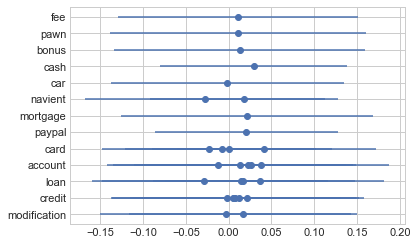

In [287]:
x = list(labels)

y = pol_mean_list

e = pol_std_list

plt.style.use('seaborn-whitegrid')

plt.errorbar(y, x, xerr=e, linestyle='', marker='o')

plt.show()

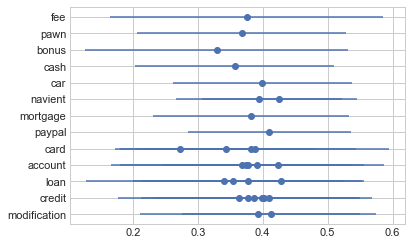

In [288]:
x = labels

y = subj_mean_list

e = subj_std_list

plt.errorbar(y, x, xerr=e, linestyle='', marker='o')

plt.show()